## Can The [NVT Ratio](http://charts.woobull.com/bitcoin-nvt-ratio/) Predict Future Returns?

**Author**: GSR <br />
**Date**: 2018-03-28

The creator of the NVT indicator suggests that it can be used to detect bubbles. Because of the claims the original creator made, we decided to investigate whether or not the NVT ratio had any predictive power for future returns. 

In [1]:
%matplotlib notebook

from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *

import base64
import os
import sys
import zipfile

import talib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykalman as kf
import statsmodels.api as sm
import statsmodels
import sklearn
import requests
import quandl
import time

from scipy.stats import jarque_bera, linregress
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller

qb = QuantBook()

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Constants
RESOLUTION = Resolution.Daily
START = datetime(2017,2,10)
END = datetime(2017,12,31)

# Quandl stuff
Q_DATA_BUNDLES = {
    'BCHAIN/TRFUS': None, # Bitcoin Total Transaction Fees USD
    'BCHAIN/AVBLS': None, # Average Block Size
    'BCHAIN/NADDU': None, # Number of Unique Bitcoin Addresses Used
    'BCHAIN/NTRBL': None, # Number of Transactions Per Block
    'BCHAIN/NTREP': None, # Number of Transactions Excluding Popular Addresses
    'BCHAIN/NTRAN': None, # Number of Transactions
    'BCHAIN/MKTCP': None, # Bitcoin Market Cap
    'BCHAIN/TOUTV': None, # Total Output Transaction Volume
    'BCHAIN/ETRVU': None, # Estimated Transaction Volume USD
    'BCHAIN/ETRAV': None, # Estimated Transaction Volume
    #'BCHAIN/TOTBC': None, # Total Bitcoins
}
decode_iterations = 12

# Insert your Quandl API key here
quandl_api_key = b''

for i in range(decode_iterations):
    quandl_api_key = base64.b64decode(quandl_api_key)
    
quandl_data = quandl.get(
    list(Q_DATA_BUNDLES.keys()),
    api_key=quandl_api_key.decode('utf-8'),
    start_date=str(START.date()),
    end_date=str(END.date())
)
quandl_data.columns = Q_DATA_BUNDLES.keys()
quandl_data['POPTRANS'] = quandl_data['BCHAIN/NTRAN'] - quandl_data['BCHAIN/NTREP']

# Load cryptocurrency market data
crypto_assets = map(qb.AddCrypto, ['BTCUSD', 'ETHUSD', 'LTCUSD'])
crypto_symbols = [asset.Symbol for asset in crypto_assets]

history = qb.History(qb.Securities.Keys, START - timedelta(days=1), END, RESOLUTION).unstack(level=0)

In [3]:
nvt_ratio = quandl_data['BCHAIN/MKTCP'] / quandl_data['BCHAIN/ETRVU']

kalman_filter = kf.KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

filtered_nvt, _ = kalman_filter.filter(nvt_ratio)

In this demonstration, we will be using a Kalman filter to get a better representation of our data instead of the volatile movement. We compare it against a 14 day moving average (as used in the original [article](http://charts.woobull.com/bitcoin-nvt-ratio/)) and

<IPython.core.display.Javascript object>


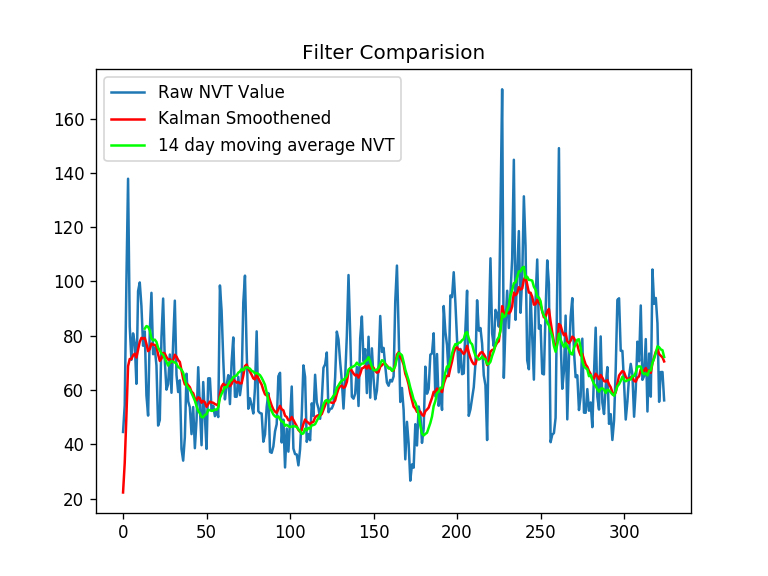

<IPython.core.display.Javascript object>


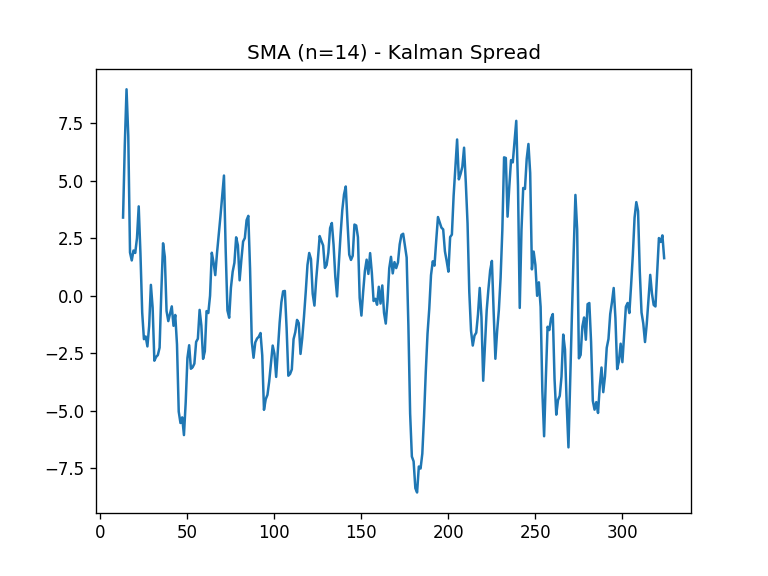

<IPython.core.display.Javascript object>


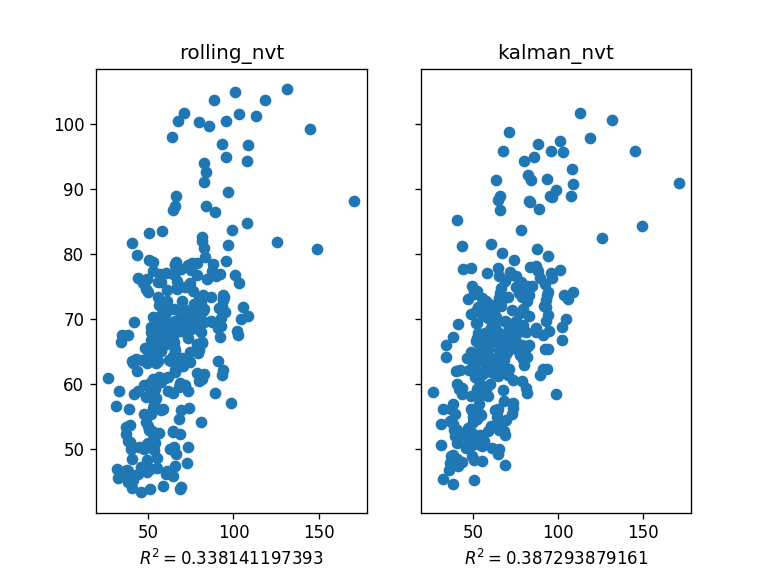

In [4]:
n = 14
rolling_nvt = nvt_ratio.rolling(window=n).mean()
filtered_clean_nvt = np.array([i[0] for i in filtered_nvt])


plt.figure()
plt.plot(nvt_ratio.values, label='Raw NVT Value')
plt.plot(filtered_clean_nvt, c='#ff0000', label='Kalman Smoothened')
plt.plot(rolling_nvt.values, c='#00ff00', label='14 day moving average NVT')
plt.legend()
plt.title('Filter Comparision')
plt.figure()
plt.plot(rolling_nvt.values - filtered_clean_nvt)
plt.title('SMA (n=14) - Kalman Spread')

h, (ax01, ax02) = plt.subplots(1,2, sharey=True)
slope, intercept, r_value, p_value, std_err = linregress(
    nvt_ratio.iloc[n:].values, 
    rolling_nvt.iloc[n:]
)
ax01.scatter(nvt_ratio.values, rolling_nvt)
ax01.set(xlabel=r'$R^{2} = %s$' % r_value**2, title='rolling_nvt')

slope, intercept, r_value, p_value, std_err = linregress(
    nvt_ratio.iloc[n:].values, 
    filtered_clean_nvt[n:]
)
ax02.scatter(nvt_ratio.iloc[n:].values, filtered_clean_nvt[n:])
ax02.set(xlabel=r'$R^{2} = %s$' % r_value**2, title='kalman_nvt')

# Remove the triple quotes for production, and the print statement below.
print()

Sporting a better $R^{2}$ value over the moving average filter, the Kalman filter comes out as the superior data smoothener. We will be using Kalman filtered data from here onward.

In [5]:
def generate_dist_graph(asset='BTCUSD', field='close', lags=0, high_quantile_value=0.90, low_quantile_value=0.10):
    nvt_ratio_1 = quandl_data['BCHAIN/MKTCP'] / (quandl_data['BCHAIN/TOUTV'] * history['close']['BTCUSD'])
    nvt_ratio_2 = quandl_data['BCHAIN/MKTCP'] / quandl_data['BCHAIN/ETRVU']
    nvt_ratio_3 = quandl_data['BCHAIN/MKTCP'] / (quandl_data['BCHAIN/ETRAV'] * history['close']['BTCUSD'])

    filt = kf.KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=0,
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.01
    )

    state_means, _ = filt.filter(nvt_ratio_2)
    
    state_clean = pd.Series([i[0] for i in state_means], index=history[field][asset].index).pct_change()
    high_quantile = state_clean.quantile(high_quantile_value)
    low_quantile = state_clean.quantile(low_quantile_value)

    state_filtered_high = state_clean[state_clean.shift(lags) > high_quantile]
    state_filtered_low = state_clean[state_clean.shift(lags) < low_quantile]
    
    f, axes = plt.subplots(figsize=(11, 9.75), nrows=2, ncols=3)

    history[field][asset].pct_change().loc[state_filtered_high.index].plot.kde(
        ax=axes[0,0], 
        title=r'High Quantile PDF [$q = %s, k = %s$, %s]' % (high_quantile_value, lags, field)
    )
    history[field][asset].pct_change().loc[state_filtered_high.index].plot.box(
        ax=axes[0,1], 
        title=r'High Quantile Box'
    )
    axes[0,2].scatter(
        y=history[field][asset].pct_change().loc[state_filtered_high.index],
        x=state_filtered_high.shift(lags),
    )
    axes[0,2].set(
        ylabel='%s Percentage Change' % asset,
        xlabel='High Quantile Filter',
        title=r'$R^2 = %s$' % linregress(
            state_filtered_high,
            history[field][asset].pct_change().loc[state_filtered_high.index]
        )[2]**2
    )
    
    history[field][asset].pct_change().loc[state_filtered_low.index].plot.kde(
        ax=axes[1,0], 
        title='Low Quantile PDF [$q = %s, k = %s$, %s]' % (low_quantile_value, lags, field)
    )
    history[field][asset].pct_change().loc[state_filtered_low.index].plot.box(
        ax=axes[1,1], 
        title='Low Quantile Box'
    )
    axes[1,2].scatter(
        y=history[field][asset].pct_change().loc[state_filtered_low.index],
        x=state_filtered_low.shift(lags),
    )
    axes[1,2].set(
        ylabel='%s Percentage Change' % asset,
        xlabel='Low Quantile Filter',
        title=r'$R^2 = %s$' % linregress(
            state_filtered_low,
            history[field][asset].pct_change().loc[state_filtered_low.index]
        )[2]**2
    )

Here, we can see the distribution of our returns if we chose the top and bottom quantiles.
For our first example, we will choose to use the **`BTCUSD`** pair and the `close` field, with $k = 0$ <br />

<IPython.core.display.Javascript object>


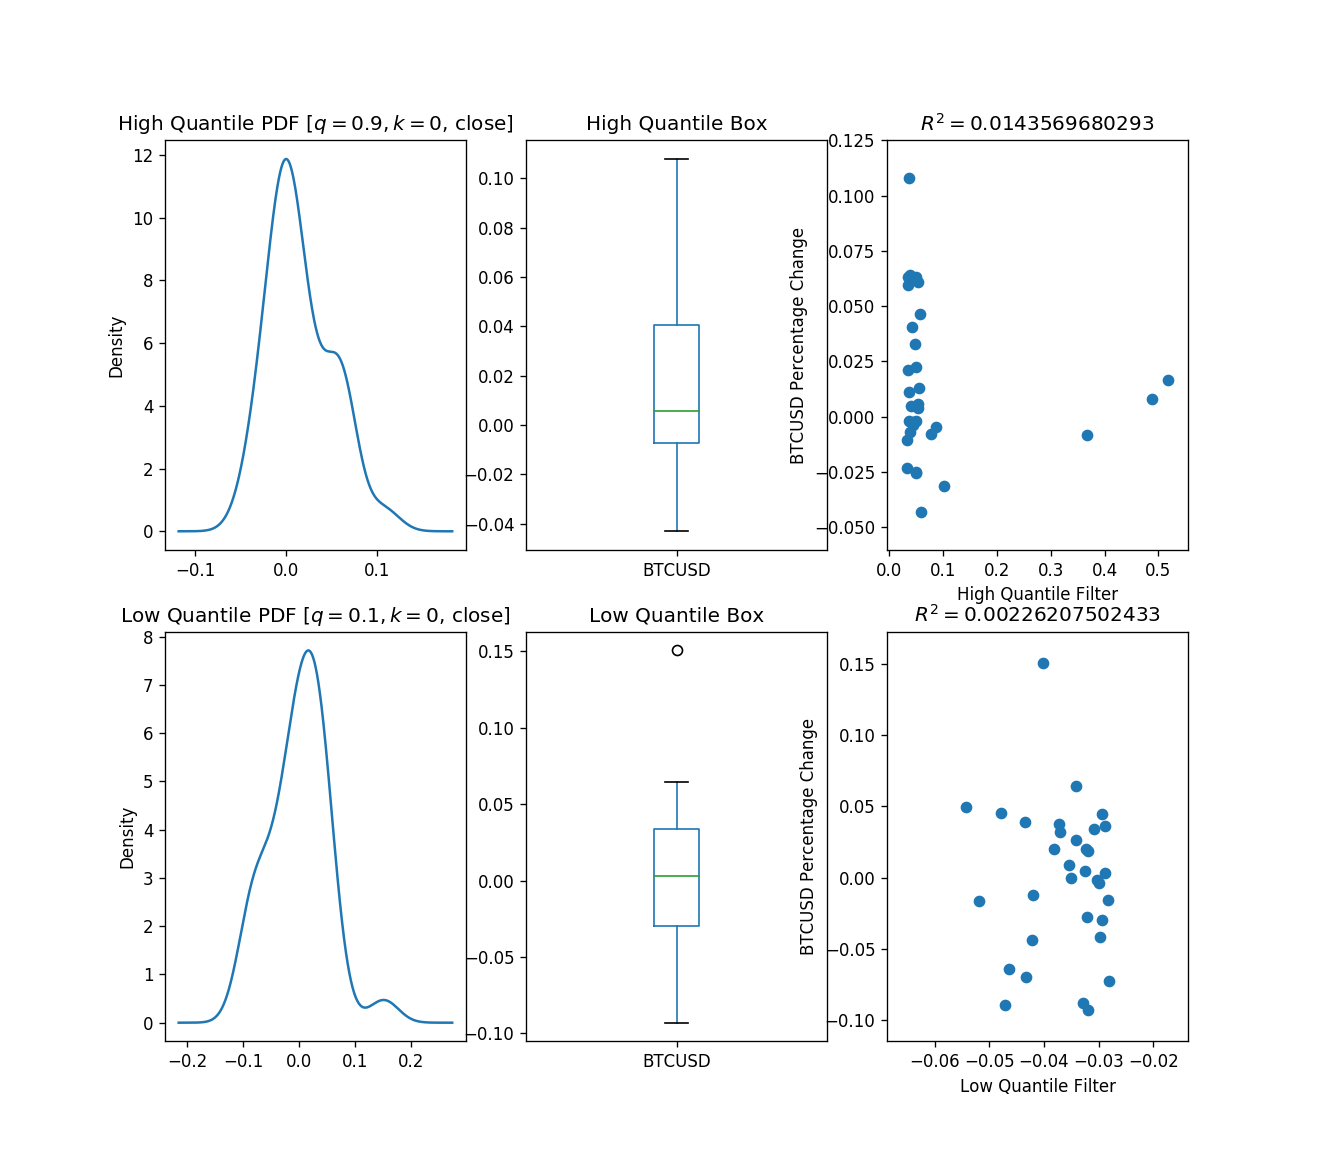

In [6]:
generate_dist_graph(asset='BTCUSD', field='close', lags=0)

One interesting thing to note is that high quantile closing values have a skewed right distribution, indicating a more positive NVT value for a positive percentage gain. This is most likely due to the fact that NVT contains the **`Market Cap`** `(BCHAIN/MKTCP)` variable as a denomenator, which is heavily based on the market price of the asset ($\text{token supply} * \text{market price}$). The opposite seems to hold up as well for low quantile values.

Let's examine other fields and see if they are correlated to NVT changes.

First, we'll begin with the `volume` field. Then, we will introduce lags to both the `close` and `volume` fields to see if they are predictable from NVT changes.

<IPython.core.display.Javascript object>


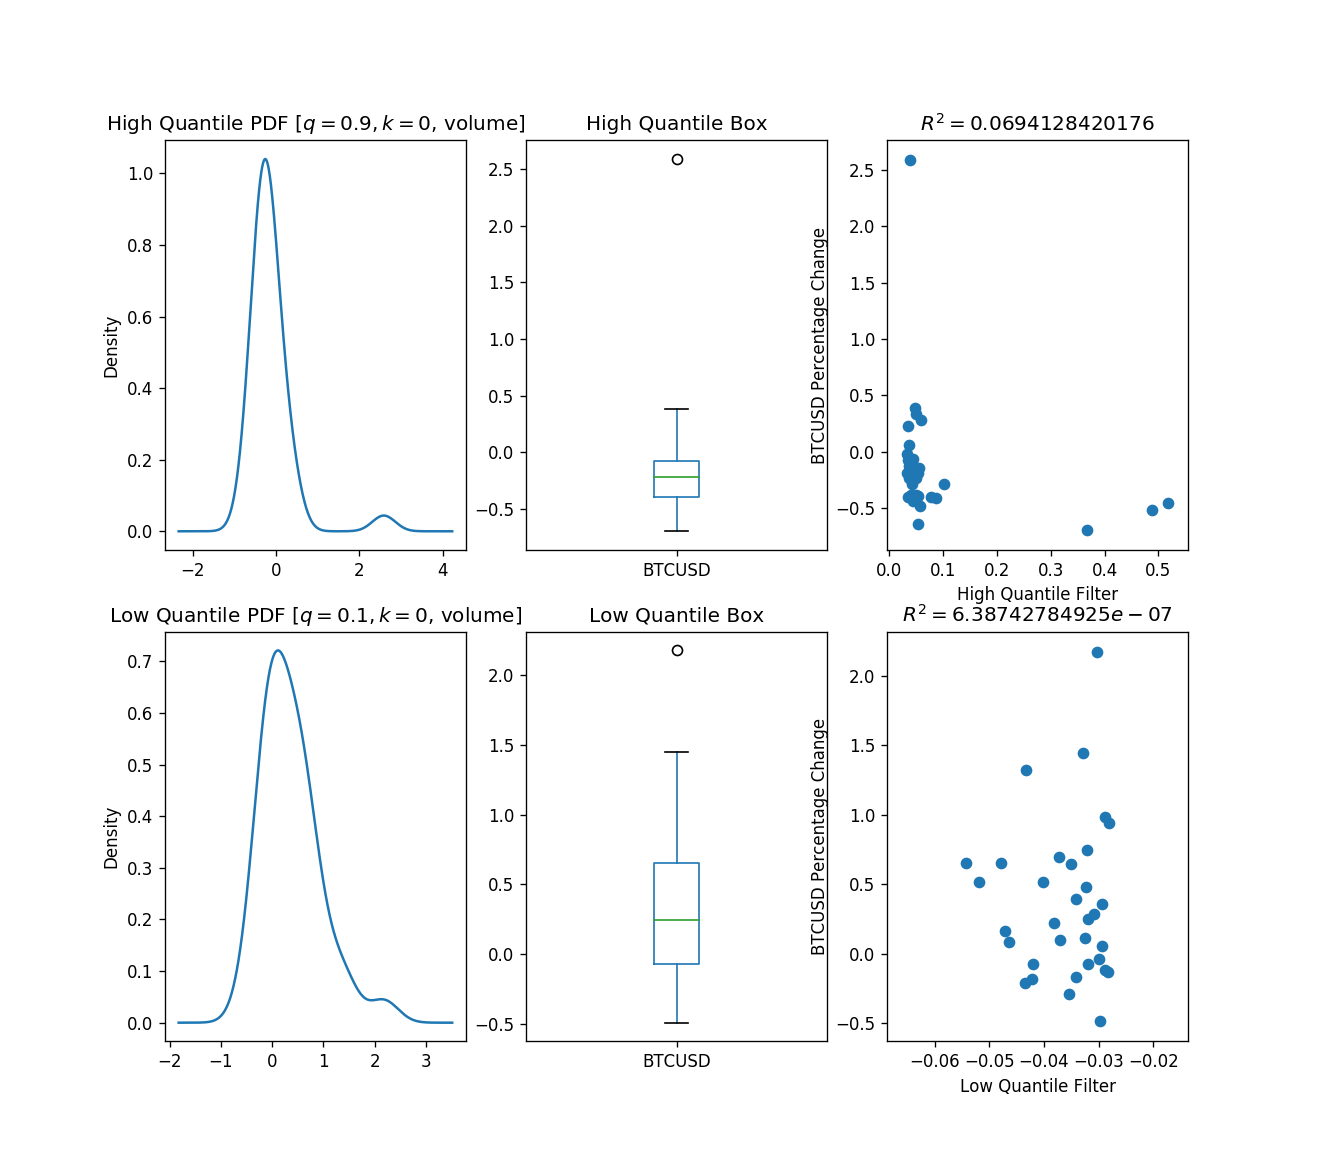

In [7]:
generate_dist_graph(field='volume')

Both high and low quantiles exhibited high kurtosis with no particular skew. However, the high quantile exhibits an $R^{2}$ value of approximately $0.07$ . Let's begin introducing lag ($k$) into our analysis.

In [206]:
#generate_dist_graph(field='close', lags=1)

In [207]:
#generate_dist_graph(field='volume', lags=1)

In [208]:
#generate_dist_graph(field='close', lags=2)

In [209]:
#generate_dist_graph(field='volume', lags=2)

### Conclusion

For the sake of brevity, we won't be continuing any further. As we're only interested in day-to-day (interday) returns, there is no point in continuing. In addition, we may be introducing multiple comparisions bias by incrementing our lag variable, and lowering our sample size in the process. As a result, we can conclude that the **NVT Ratio** contains ** *no predictive power for future returns in the short term in the scope of our exploration.* **